In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import keras_tuner
from keras import layers

# Fetching the data
data = pd.read_csv('daily_revenue.csv', sep='\t')
data.head()

2024-01-12 16:05:56.074945: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-12 16:05:56.101820: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 16:05:56.482946: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


,Unnamed: 0,date,revenue,discount_rate,coupon_rate
0,1,01/01/18,6270839,34.27%,1.09%
1,2,02/01/18,8922076,30.87%,1.08%
2,3,03/01/18,8446101,28.11%,1.01%
3,4,04/01/18,7785798,27.32%,0.96%
4,5,05/01/18,6375303,25.70%,0.90%


In [2]:
# Dropping the  "Unnamed: 0" column
data.drop('Unnamed: 0', axis=1, inplace=True)

# Converting the "date" column to a datetime column
dt = pd.to_datetime(data['date'], infer_datetime_format=True)

/tmp/ipykernel_15749/1040822924.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(data['date'], infer_datetime_format=True)
/tmp/ipykernel_15749/1040822924.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(data['date'], infer_datetime_format=True)


In [3]:
dt

0      2018-01-01
1      2018-02-01
2      2018-03-01
3      2018-04-01
4      2018-05-01
          ...    
1790   2022-11-26
1791   2022-11-27
1792   2022-11-28
1793   2022-11-29
1794   2022-11-30
Name: date, Length: 1795, dtype: datetime64[ns]

In [4]:
# Joining the 2 dataframes
data = pd.concat([dt, data[[ 'discount_rate', 'coupon_rate', 'revenue']]], axis=1)
data.set_index(['date'], inplace=True)
data.head()

,discount_rate,coupon_rate,revenue
date,,,
2018-01-01,34.27%,1.09%,6270839
2018-02-01,30.87%,1.08%,8922076
2018-03-01,28.11%,1.01%,8446101
2018-04-01,27.32%,0.96%,7785798
2018-05-01,25.70%,0.90%,6375303


In [5]:
# Replacing the "%" from "discount_rate" and "revenue" columns
# Converting the values to integer and float values
data['discount_rate'] = data['discount_rate'].str.replace('%','')
data['coupon_rate'] = data['coupon_rate'].str.replace('%','')
convert_dict = {'revenue': int,
                'discount_rate': float,
                'coupon_rate' : float
                }
data = data.astype(convert_dict)
data['discount_rate'] = data['discount_rate'] / 100
data['coupon_rate'] = data['coupon_rate'] / 100
data.head()

,discount_rate,coupon_rate,revenue
date,,,
2018-01-01,0.3427,0.0109,6270839
2018-02-01,0.3087,0.0108,8922076
2018-03-01,0.2811,0.0101,8446101
2018-04-01,0.2732,0.0096,7785798
2018-05-01,0.2570,0.0090,6375303


In [6]:
# Normalising the values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler = scaler.fit(data[['revenue', 'discount_rate', 'coupon_rate']])
data = scaler.transform(data[['revenue', 'discount_rate', 'coupon_rate']])

data = pd.DataFrame(data)
data.head()

,0,1,2
0,0.033234,1.000000,0.082204
1,0.069186,0.870919,0.081301
2,0.062732,0.766135,0.074977
3,0.053778,0.736143,0.070461
4,0.034650,0.674639,0.065041


In [7]:
# Splitting the dataframe into train/test
df_test = data.tail(359)
df_train = data.head(1436)

# Setting the metric for calculation
from sklearn.metrics import mean_absolute_error

In [8]:
# Creating the dataset in the proper format
n_future = 30  # Number of days we want to look into the future based on the past days.
trainX = []
trainY = []
n_past = 30  # Number of past days we want to use to predict the future.
for i in range(n_past, len(df_train) - n_future + 1):
    dt = df_train.values
    dt = dt.astype('float32')
    trainX.append(dt[i - n_past:i, 0:dt.shape[1] - 1])
    trainY.append(dt[i - n_past:i, -1])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (1377, 30, 2).
trainY shape == (1377, 30).


In [9]:
testX = []
testY = []

for i in range(n_past, len(df_test) - n_future + 1):
    dt = df_test.values
    dt = dt.astype('float32')
    testX.append(dt[i - n_past:i, 0:dt.shape[1] - 1])
    testY.append(dt[i - n_past:i, -1])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

testX shape == (300, 30, 2).
testY shape == (300, 30).


In [10]:
# Building the model
model = tf.keras.models.Sequential([tf.keras.layers.LSTM(units=16, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True),
                                   tf.keras.layers.Dense(1, activation='sigmoid')])
model.summary()
model.compile(optimizer='Adam', loss=tf.keras.losses.MeanAbsoluteError())
epochs_hist = model.fit(trainX, trainY, epochs = 100, batch_size = 50, validation_data=(testX, testY))

2024-01-12 16:05:57.137835: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-12 16:05:57.153290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-12 16:05:57.153417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 16)            1216      
                                                                 
 dense (Dense)               (None, 30, 1)             17        
                                                                 
Total params: 1233 (4.82 KB)
Trainable params: 1233 (4.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


2024-01-12 16:05:57.928615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-12 16:05:57.951511: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f285c66c790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-12 16:05:57.951529: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-01-12 16:05:57.954110: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-12 16:05:57.962548: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-12 16:05:57.994024: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-12 16:

28/28 [==============================] - 1s 20ms/step - loss: 0.4454 - val_loss: 0.4206
Epoch 2/100
28/28 [==============================] - 0s 14ms/step - loss: 0.4230 - val_loss: 0.3857
Epoch 3/100
28/28 [==============================] - 0s 16ms/step - loss: 0.2875 - val_loss: 0.1361
Epoch 4/100
28/28 [==============================] - 0s 14ms/step - loss: 0.1173 - val_loss: 0.1075
Epoch 5/100
28/28 [==============================] - 0s 16ms/step - loss: 0.1004 - val_loss: 0.1001
Epoch 6/100
28/28 [==============================] - 0s 16ms/step - loss: 0.0935 - val_loss: 0.0956
Epoch 7/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0888 - val_loss: 0.0920
Epoch 8/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0848 - val_loss: 0.0891
Epoch 9/100
28/28 [==============================] - 0s 17ms/step - loss: 0.0814 - val_loss: 0.0865
Epoch 10/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0785 - val_loss: 0.0843
Epoch 11/10

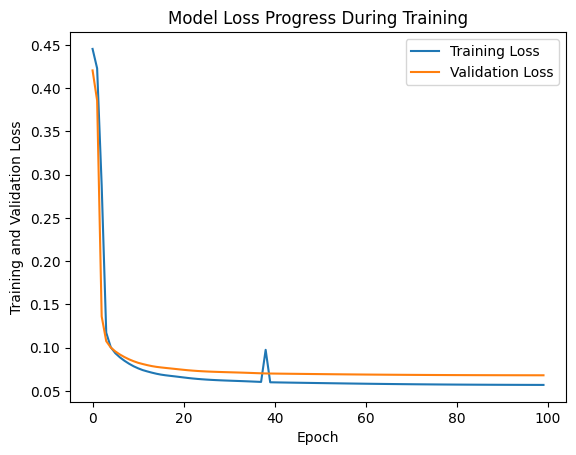

In [11]:
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])
plt.title('Model Loss Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [12]:
testPredict = model.predict(testX)
testPredict = np.reshape(testPredict, testY.shape)
initial_model_error = mean_absolute_error(testY, testPredict)
print("Mean Absolute Error achieved : ", initial_model_error)

10/10 [==============================] - 0s 5ms/step
Mean Absolute Error achieved :  0.06801396


In [13]:
# Using Hyperparameter Tuning
def build_model(hp):
    model = keras.Sequential()
    dropout_fraction = hp.Choice('rate', values=[0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(layers.LSTM(units=hp.Int("units" + str(i), min_value=32, max_value=512, step=32),
                          activation=hp.Choice("activation" + str(i), ["relu", "tanh", "sigmoid"]),
                          input_shape=(trainX.shape[1], trainX.shape[2]),
                          return_sequences=False))
    model.add(layers.Dropout(rate=dropout_fraction))
    model.add(layers.Dense(trainY.shape[1]))
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.mean_absolute_error,
    )
    return model


tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective=keras_tuner.Objective("val_loss", direction="min"),
    max_trials=50,
    executions_per_trial=3,
    overwrite=True,
    directory="Random_Search",
    project_name="Daily_Revenue_Time_Series",
)

tuner.search(trainX, trainY, epochs=10, validation_data=(testX, testY), verbose=1)

Trial 50 Complete [00h 00m 23s]
val_loss: 0.05888601144154867

Best val_loss So Far: 0.05866657570004463
Total elapsed time: 00h 15m 37s


In [14]:
# Fetching the best set of parameters
tuner.get_best_hyperparameters()[0].values

{'rate': 0.5, 'units329': 320, 'activation329': 'relu', 'learning_rate': 0.01}

In [15]:
# Fetching the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Fitting the best model
best_model.fit(trainX, trainY, epochs=20, batch_size=64, validation_data=(testX, testY), verbose=1)

Epoch 1/20
22/22 [==============================] - 1s 22ms/step - loss: 0.0406 - val_loss: 0.0586
Epoch 2/20
22/22 [==============================] - 0s 16ms/step - loss: 0.0402 - val_loss: 0.0585
Epoch 3/20
22/22 [==============================] - 0s 19ms/step - loss: 0.0401 - val_loss: 0.0585
Epoch 4/20
22/22 [==============================] - 0s 19ms/step - loss: 0.0402 - val_loss: 0.0586
Epoch 5/20
22/22 [==============================] - 0s 16ms/step - loss: 0.0402 - val_loss: 0.0585
Epoch 6/20
22/22 [==============================] - 0s 17ms/step - loss: 0.0401 - val_loss: 0.0585
Epoch 7/20
22/22 [==============================] - 0s 18ms/step - loss: 0.0402 - val_loss: 0.0585
Epoch 8/20
22/22 [==============================] - 0s 15ms/step - loss: 0.0400 - val_loss: 0.0585
Epoch 9/20
22/22 [==============================] - 0s 19ms/step - loss: 0.0396 - val_loss: 0.0587
Epoch 10/20
22/22 [==============================] - 0s 17ms/step - loss: 0.0402 - val_loss: 0.0586
Epoch 11/

In [16]:
# Predicting the results with the best model
testPredict = best_model.predict(testX)
testPredict = np.reshape(testPredict, testY.shape)
best_model_error = mean_absolute_error(testY, testPredict)
print("Mean Absolute Error achieved : ", best_model_error)
per_diff = (initial_model_error - best_model_error) / initial_model_error) * 100
print("%age difference b/w the best model and initial model is : ", per_diff)

10/10 [==============================] - 0s 4ms/step
Mean Absolute Error achieved :  0.058491644
%age difference b/w the best model and initial model is :  0.1400053


In [ ]:
# Saving the Model
model.save('daily_revenue_time_series.keras')